In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

device: cuda:0


In [3]:
class PINN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_layers = 4, neurons = 100):
        super(PINN, self).__init__()
        layers = [nn.Linear(in_dim, neurons), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(neurons, neurons), nn.Tanh()]
        layers.append(nn.Linear(neurons, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self,x):
        return self.net(x)
    

net = PINN(in_dim = 1, out_dim = 1).to(device)

In [4]:
# Training data

t_train = torch.linspace(0, 5, 100).view(-1, 1).to(device)
u_train = (0.5 * (t_train **2) + t_train).to(device)

In [5]:
# Generate Collocation Points

N_f = 10000
t_f = torch.linspace(0,5,N_f).view(-1,1).to(device).requires_grad_(True)


# Generate IC Points

t_i = torch.tensor([[0.0]], device = device)


In [6]:
def compute_residuals():
    u_f_pred = net(t_f)
    u_t = autograd.grad(u_f_pred,t_f,grad_outputs=torch.ones_like(u_f_pred), create_graph=True)[0]
    
    res_pde = u_t - t_f


    u_i_pred = net(t_i)

    res_ic = u_i_pred
    

    return res_pde, res_ic

In [12]:
def compute_losses():
    res_pde, res_ic = compute_residuals()

    loss_pde = torch.mean(res_pde**2)
    loss_ic = torch.mean(res_ic **2)

    u_pred = net(t_train)

    loss_data = torch.mean((u_pred - u_train)**2)

    total_loss = loss_pde + loss_ic + loss_data

    return loss_pde, loss_ic,loss_data, total_loss

In [13]:
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

In [15]:
num_epochs = 5000

loss_pde_list, loss_ic_list, loss_data_list, total_loss_list = [],[],[],[]

for epoch in range(num_epochs):
    optimizer.zero_grad()

    loss_pde, loss_ic, loss_data, total_loss = compute_losses()

    loss_pde.backward(retain_graph=True)
    loss_ic.backward(retain_graph=True)
    loss_data.backward()


    optimizer.step()

    loss_pde_list.append(loss_pde.item()); loss_ic_list.append(loss_ic.item()); loss_data_list.append(loss_data.item()); total_loss_list.append(total_loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: loss_pde={loss_pde.item():.3e},  loss_ic={loss_ic.item():.3e}, loss_data={loss_data.item():.3e}, total={total_loss.item():.3e}")



Epoch 0: loss_pde=1.121e-05,  loss_ic=5.029e-07, loss_data=8.397e+00, total=8.397e+00
Epoch 500: loss_pde=6.436e-01,  loss_ic=2.684e-02, loss_data=1.013e-01, total=7.718e-01
Epoch 1000: loss_pde=6.438e-01,  loss_ic=2.685e-02, loss_data=1.010e-01, total=7.717e-01
Epoch 1500: loss_pde=6.438e-01,  loss_ic=2.686e-02, loss_data=1.010e-01, total=7.717e-01
Epoch 2000: loss_pde=6.438e-01,  loss_ic=2.686e-02, loss_data=1.010e-01, total=7.717e-01
Epoch 2500: loss_pde=6.445e-01,  loss_ic=2.700e-02, loss_data=1.002e-01, total=7.717e-01
Epoch 3000: loss_pde=6.438e-01,  loss_ic=2.684e-02, loss_data=1.010e-01, total=7.717e-01
Epoch 3500: loss_pde=6.438e-01,  loss_ic=2.685e-02, loss_data=1.010e-01, total=7.717e-01
Epoch 4000: loss_pde=6.438e-01,  loss_ic=2.685e-02, loss_data=1.010e-01, total=7.717e-01
Epoch 4500: loss_pde=6.438e-01,  loss_ic=2.685e-02, loss_data=1.010e-01, total=7.717e-01


In [16]:
# Evaluation
t_test = torch.linspace(0, 5, 100).view(-1, 1).to(device)

net.eval()

with torch.no_grad():
    u_pred_test = net(t_test).cpu().numpy()
u_true = (0.5 * (t_test**2) + t_test).cpu().numpy()


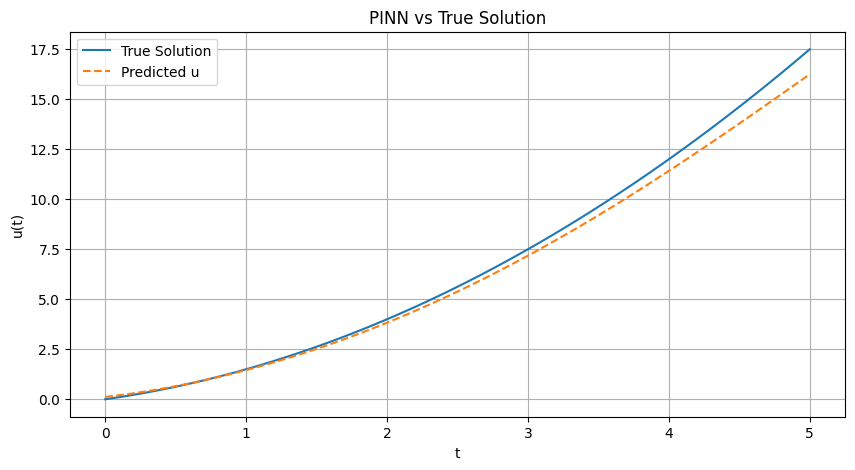

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(t_test.cpu().numpy(), u_true, label="True Solution")
plt.plot(t_test.cpu().numpy(), u_pred_test, '--', label="Predicted u")
plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("PINN vs True Solution")
plt.legend()
plt.grid(True)
plt.show()